# Sentiment Analysis WA

## Preparación de ambiente

### Carga de módulos

In [1]:
!pip install stylecloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 262 kB 7.7 MB/s 
     |████████████████████████████████| 161 kB 58.1 MB/s 
     |████████████████████████████████| 87 kB 6.7 MB/s 
     |████████████████████████████████| 87 kB 7.0 MB/s 
  Created wheel for stylecloud: filename=stylecloud-0.5.2-py3-none-any.whl size=259508 sha256=9ab9d80041a96290b73c0a171a342e3f3f17a963cff6cfe141a7c08c229febb0
  Stored in directory: /root/.cache/pip/wheels/77/42/7a/f52b5f84c04196fd4c2a3dceeb1bbeaee1c93a4fe271b5eb41
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=64a35ced0c500688cce4eaf4a76f7d716706a02f055925259cbf4c638257c099
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
  Created wheel for tinycss: filename=tinycss-0.4-py3-none-any.whl size=43955 sha256=c6c1755de20ea51d4ddb1f6ecf82e47ec1e4ab63a9964696ff2aeab124ca5862


In [2]:
# Misc
from warnings import filterwarnings

# Data Wrangling
import re
import numpy as np
import pandas as pd

# Data visualization
from PIL import Image
import cufflinks as cf
from stylecloud import gen_stylecloud

# Modeling
from keras import metrics
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import SpatialDropout1D
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Preprocessing
import nltk
import unicodedata
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Model performance
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

# Environment setup
cf.go_offline()
nltk.download("all")
filterwarnings("ignore")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

### Conexión con Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Funciones relevantes

In [4]:
def clean_text(text, pattern="[^a-zA-Z0-9 ]"):
    """Cleans the text to facilitate its analysis, it changes accented letters to its quivalent without accents, removes also special characters

    Parameters
    ----------
    text : string
        String containing text
    pattern : str, optional
        Regular expession for keeping in the string, by default ``[^a-zA-Z0-9 ]``

    Returns
    -------
    cleaned_text : string
        Cleaned string

    Example
    -------
    >>> clean_text('¡Feliz año nuevo, México!')
    >>> u'feliz ano nuevo mexico'
    """
    cleaned_text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore')
    cleaned_text = re.sub(pattern, " ", cleaned_text.decode("utf-8"), flags=re.UNICODE)
    cleaned_text = u' '.join(cleaned_text.lower().split())
    return cleaned_text

In [5]:
clean_text("¡Feliz año nuevo, México!")

'feliz ano nuevo mexico'

In [6]:
def get_wordcloud(text, icon="fas fa-comments", background_color=None, output_name="./wordcloud.png"):
    # https://fontawesome.com/icons/alicorn?s=solid
    gen_stylecloud(text=text, icon_name=icon, background_color=background_color, output_name=output_name)
    return Image.open(output_name) 

## Data Wrangling

### Carga de datos

In [7]:
df = pd.read_csv("/content/drive/MyDrive/muestra_wa.csv", on_bad_lines="skip", sep="\t")

### EDA

In [8]:
df.head()

,fecha,hora,autor,mensaje,sentimiento
0,04/05/19,3:01:44 p.m.,Davo Acosta,Ya estoy llegando,1
1,27/02/20,10:27:11 p.m.,Oscar Acosta,Ok,0
2,08/03/18,9:28:19 p.m.,Davo Acosta,Y tengo sed,0
3,29/08/18,9:11:58 a.m.,Oscar Acosta,Bambiii,1
4,27/05/19,1:57:32 p.m.,Davo Acosta,🤔,0


In [9]:
df["sentimiento"].value_counts(True)

 0    0.793333
 1    0.150000
-1    0.056667
Name: sentimiento, dtype: float64

### Remuestreo

In [10]:
dc_cat = df["sentimiento"].value_counts().to_dict()

In [11]:
dc_cat

{0: 238, 1: 45, -1: 17}

In [12]:
smallest = min(dc_cat, key=dc_cat.get)
n_min = min(dc_cat.values())

In [13]:
smallest, n_min

(-1, 17)

In [14]:
df = pd.codf = pd.concat([df[df["sentimiento"]==sent].sample(n_min) for sent in df["sentimiento"].unique()]).reset_index(drop=True)

In [15]:
df["sentimiento"].value_counts()

 1    17
 0    17
-1    17
Name: sentimiento, dtype: int64

### Análisis de texto

In [16]:
df

,fecha,hora,autor,mensaje,sentimiento
0,17/07/17,9:48:00 a.m.,Oscar Acosta,:+1:,1
1,16/08/19,11:19:18 a.m.,Davo Acosta,Si,1
2,16/01/20,8:12:52 p.m.,Davo Acosta,‎sticker omitted,1
3,12/08/18,11:37:47 a.m.,Davo Acosta,A va,1
4,08/08/18,2:03:23 p.m.,Davo Acosta,A bueno,1
5,17/08/17,4:45:15 p.m.,Oscar Acosta,école,1
6,16/12/19,11:35:02 a.m.,Davo Acosta,Le voy a poner la portada del libro de Yuya🤣,1
7,14/04/21,10:18:49 p.m.,Oscar Acosta,Simón,1
8,02/08/17,10:18:23 a.m.,Oscar Acosta,👍,1
9,17/10/17,5:34:29 p.m.,Davo Acosta,🤙🏻,1


In [17]:
index = 42

In [18]:
df.loc[index, "sentimiento"]

-1

In [19]:
df.loc[index, "mensaje"]

'No'

In [20]:
df["mensaje"] = df["mensaje"].map(clean_text)

In [21]:
df.loc[index, "mensaje"]

'no'

### Nube de palabras

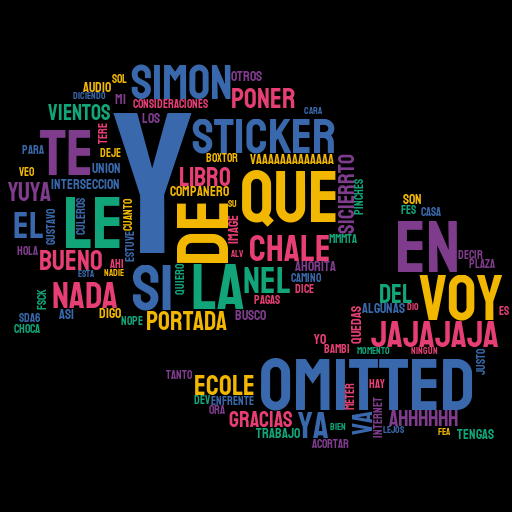

In [22]:
get_wordcloud(text = " ".join(df["mensaje"]))

## Limpieza de texto

In [23]:
stop_words = [clean_text(x) for x in stopwords.words("spanish")] + ["sticker", "media", "omitted", "image"]

In [24]:
stop_words[:10]

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se']

In [25]:
df.head()

,fecha,hora,autor,mensaje,sentimiento
0,17/07/17,9:48:00 a.m.,Oscar Acosta,1,1
1,16/08/19,11:19:18 a.m.,Davo Acosta,si,1
2,16/01/20,8:12:52 p.m.,Davo Acosta,sticker omitted,1
3,12/08/18,11:37:47 a.m.,Davo Acosta,a va,1
4,08/08/18,2:03:23 p.m.,Davo Acosta,a bueno,1


In [26]:
df.loc[index, "mensaje"]

'no'

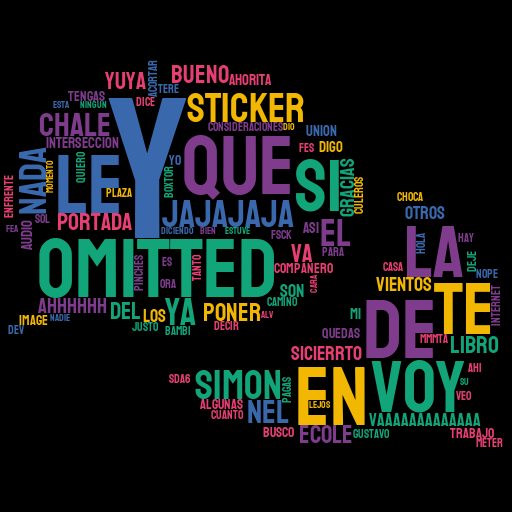

In [83]:
get_wordcloud(text = " ".join(df["mensaje"]))

In [28]:
df.shape

(51, 5)

### Vectorización

In [29]:
df["words"] = df["mensaje"].str.split()

In [30]:
df

,fecha,hora,autor,mensaje,sentimiento,words
0,17/07/17,9:48:00 a.m.,Oscar Acosta,1,1,[1]
1,16/08/19,11:19:18 a.m.,Davo Acosta,si,1,[si]
2,16/01/20,8:12:52 p.m.,Davo Acosta,sticker omitted,1,"[sticker, omitted]"
3,12/08/18,11:37:47 a.m.,Davo Acosta,a va,1,"[a, va]"
4,08/08/18,2:03:23 p.m.,Davo Acosta,a bueno,1,"[a, bueno]"
5,17/08/17,4:45:15 p.m.,Oscar Acosta,ecole,1,[ecole]
6,16/12/19,11:35:02 a.m.,Davo Acosta,le voy a poner la portada del libro de yuya,1,"[le, voy, a, poner, la, portada, del, libro, d..."
7,14/04/21,10:18:49 p.m.,Oscar Acosta,simon,1,[simon]
8,02/08/17,10:18:23 a.m.,Oscar Acosta,,1,[]
9,17/10/17,5:34:29 p.m.,Davo Acosta,,1,[]


In [31]:
df["words"].str.len().describe(percentiles=[.95])

count    51.000000
mean      2.941176
std       3.754527
min       0.000000
50%       2.000000
95%      10.000000
max      20.000000
Name: words, dtype: float64

In [32]:
MAX_NB_WORDS = 250
MAX_SEQUENCE_LENGTH = 15
EMBEDDING_DIM = 3

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['mensaje'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 104 unique tokens.


In [33]:
word_index

{'a': 1,
 'y': 2,
 'omitted': 3,
 'de': 4,
 'en': 5,
 'que': 6,
 'si': 7,
 'le': 8,
 'voy': 9,
 'la': 10,
 'te': 11,
 'me': 12,
 'no': 13,
 'sticker': 14,
 'simon': 15,
 'jajajaja': 16,
 'el': 17,
 'ya': 18,
 'nada': 19,
 'chale': 20,
 'nel': 21,
 '1': 22,
 'va': 23,
 'bueno': 24,
 'ecole': 25,
 'poner': 26,
 'portada': 27,
 'del': 28,
 'libro': 29,
 'yuya': 30,
 'ahhhhhh': 31,
 'sicierrto': 32,
 'vientos': 33,
 'gracias': 34,
 'vaaaaaaaaaaaaa': 35,
 'los': 36,
 'otros': 37,
 'son': 38,
 'interseccion': 39,
 'union': 40,
 'asi': 41,
 'audio': 42,
 'ahorita': 43,
 'digo': 44,
 'mi': 45,
 'companero': 46,
 'image': 47,
 'quedas': 48,
 'trabajo': 49,
 'yo': 50,
 'busco': 51,
 'tengas': 52,
 'algunas': 53,
 'consideraciones': 54,
 'bambi': 55,
 'decir': 56,
 'gustavo': 57,
 'deje': 58,
 'fes': 59,
 'veo': 60,
 'ahi': 61,
 'para': 62,
 'acortar': 63,
 'camino': 64,
 'fsck': 65,
 'dev': 66,
 'sda6': 67,
 'justo': 68,
 'enfrente': 69,
 'plaza': 70,
 'sol': 71,
 'cuanto': 72,
 'pagas': 73,
 'i

In [34]:
X = tokenizer.texts_to_sequences(df['mensaje'].values)

In [36]:
X

[[22],
 [7],
 [14, 3],
 [1, 23],
 [1, 24],
 [25],
 [8, 9, 1, 26, 10, 27, 28, 29, 4, 30],
 [15],
 [],
 [],
 [31, 32],
 [33],
 [16],
 [15],
 [16],
 [34],
 [35],
 [7],
 [2, 36, 37, 38, 4, 39, 2, 40, 2, 41],
 [42, 3],
 [43, 8, 44, 1, 45, 46],
 [47, 3],
 [2, 7, 11, 48, 5, 17, 49, 50, 51, 6, 52, 53, 54],
 [55, 8, 9, 1, 56, 1, 57, 6, 12, 58, 5, 10, 59, 2, 11, 60, 61, 62, 63, 64],
 [65, 66, 67],
 [14, 3],
 [68, 69, 4, 70, 17, 71],
 [72, 73, 4, 74, 5, 10, 75],
 [76],
 [77],
 [2, 18, 13, 78, 79, 1, 80],
 [],
 [18, 12, 9],
 [81, 6, 82, 83],
 [12, 84],
 [],
 [13, 85, 19],
 [86],
 [87],
 [88, 89],
 [],
 [20],
 [13],
 [90, 11, 91, 92],
 [21],
 [93, 94, 95, 96],
 [97, 98, 99],
 [],
 [20],
 [5, 100, 101, 102, 103, 19, 1, 104],
 [21, 6]]

In [35]:
len(X)

51

In [37]:
df.shape

(51, 6)

In [38]:
type(X)

list

In [39]:
X[0]

[22]

In [41]:
len(X[0]), len(X[-1])

(1, 2)

### Padding

In [42]:
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (51, 15)


In [43]:
df.shape

(51, 6)

In [44]:
len(X[0]), len(X[1])

(15, 15)

### Padding

In [45]:
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (51, 15)


In [46]:
X

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  22],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   7],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         14,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          1,  23],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          1,  24],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  25],
       [  0,   0,   0,   0,   0,   8,   9,   1,  26,  10,  27,  28,  29,
          4,  30],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  15],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
       

### Preparación de la target

In [47]:
le = LabelEncoder()

In [48]:
y = le.fit_transform(df["sentimiento"])

In [49]:
y

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [50]:
y = to_categorical(y)

In [51]:
y[:5]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [52]:
X[:5]

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 22],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 14,  3],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 23],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 24]],
      dtype=int32)

### Train-test split

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.2, shuffle=True)

## Modelado

### Estructura base

In [54]:
model = Sequential()

### Capa de Embedding

In [55]:
Embedding?

In [56]:
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))

### Dropout (spatial)

In [57]:
SpatialDropout1D?

In [58]:
model.add(SpatialDropout1D(0.2))

### LSTM

In [59]:
model.add(LSTM(3, activation="tanh"))

### Capa sigmoide

In [60]:
model.add(Dense(5, activation="sigmoid"))

### Capa de salida

In [61]:
model.add(Dense(len(le.classes_), activation='softmax'))

### Configuración del modelo

In [62]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [63]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 3)             750       
                                                                 
 spatial_dropout1d (SpatialD  (None, 15, 3)            0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 3)                 84        
                                                                 
 dense (Dense)               (None, 5)                 20        
                                                                 
 dense_1 (Dense)             (None, 3)                 18        
                                                                 
Total params: 872
Trainable params: 872
Non-trainable params: 0
__________________________________________________________

### Callbacks

In [65]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, min_delta=0.0000001)

In [66]:
checkpoint = ModelCheckpoint('models/wa/model_{val_accuracy:.3f}.h5',
                             save_best_only=True,
                             save_weights_only=False,
                             monitor='val_accuracy')

### Entrenamiento

In [67]:
history = model.fit(X_train, y_train, epochs=1000, batch_size=1024, callbacks=[early_stopping, checkpoint], validation_data=(X_test, y_test))

Epoch 1/1000
1/1 [==============================] - 4s 4s/step - loss: 1.1025 - accuracy: 0.3500 - val_loss: 1.1538 - val_accuracy: 0.2727
Epoch 2/1000
1/1 [==============================] - 0s 41ms/step - loss: 1.1022 - accuracy: 0.3500 - val_loss: 1.1528 - val_accuracy: 0.2727
Epoch 3/1000
1/1 [==============================] - 0s 38ms/step - loss: 1.1017 - accuracy: 0.3500 - val_loss: 1.1518 - val_accuracy: 0.2727
Epoch 4/1000
1/1 [==============================] - 0s 41ms/step - loss: 1.1012 - accuracy: 0.3500 - val_loss: 1.1508 - val_accuracy: 0.2727
Epoch 5/1000
1/1 [==============================] - 0s 46ms/step - loss: 1.1010 - accuracy: 0.3500 - val_loss: 1.1498 - val_accuracy: 0.2727
Epoch 6/1000
1/1 [==============================] - 0s 38ms/step - loss: 1.1003 - accuracy: 0.3500 - val_loss: 1.1488 - val_accuracy: 0.2727
Epoch 7/1000
1/1 [==============================] - 0s 41ms/step - loss: 1.1001 - accuracy: 0.3500 - val_loss: 1.1479 - val_accuracy: 0.2727
Epoch 8/1000
1/

### Análisis de resultados

In [68]:
loss, acc = model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 22ms/step - loss: 1.1398 - accuracy: 0.2727


In [69]:
loss

1.1397868394851685

In [70]:
acc

0.27272728085517883

### Predicción

In [71]:
new_mensaje = ['Vientos']
new_mensaje = [clean_text(x) for x in new_mensaje]

seq = tokenizer.texts_to_sequences(new_mensaje)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)

1/1 [==============================] - 1s 507ms/step


In [72]:
pred

array([[0.35076162, 0.37314585, 0.27609262]], dtype=float32)

In [73]:
le.inverse_transform(np.argmax(pred, axis=1))

array([0])

#### Dataset completo

In [74]:
full = pd.read_csv("/content/drive/MyDrive/whats.csv", sep="\t")

In [75]:
full

,fecha,hora,autor,mensaje
0,23/06/17,4:55:01 p.m.,Davo Acosta,Ooooo
1,23/06/17,4:55:11 p.m.,Davo Acosta,Entonces mañana llega
2,23/06/17,5:01:32 p.m.,Oscar Acosta,¿Crees?
3,23/06/17,5:02:19 p.m.,Oscar Acosta,Yo digo que hasta el lunes
4,23/06/17,5:02:25 p.m.,Oscar Acosta,Porque se hacen bien weyes
...,...,...,...,...
15356,25/09/22,12:34:58 a.m.,Oscar Acosta,‎sticker omitted
15357,27/09/22,9:16:40 a.m.,Oscar Acosta,Creo que es lo que me decías:
15358,27/09/22,9:16:55 a.m.,Davo Acosta,Simón
15359,27/09/22,9:17:03 a.m.,Davo Acosta,‎sticker omitted


In [76]:
full["mensaje"] = full["mensaje"].map(clean_text)

In [77]:
seq = tokenizer.texts_to_sequences(full["mensaje"])

In [78]:
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)

In [79]:
pred = model.predict(padded)

481/481 [==============================] - 1s 2ms/step


In [80]:
full["sentimiento"] = le.inverse_transform(np.argmax(pred, axis=1))

In [82]:
full.loc[[15000], :]

,fecha,hora,autor,mensaje,sentimiento
15000,19/06/22,6:29:40 p.m.,Oscar Acosta,image omitted,0
